In [1]:
%matplotlib inline
from config_calc import *

import matplotlib
import matplotlib.pyplot as plt
from cartopy.util import add_cyclic_point
import matplotlib.gridspec as gridspec
plt.rcParams['mathtext.default']='regular'

import cmocean
import plot_tools
import proc_cesm_le

In [2]:
%%time

region_names = ['Global','Tropics','Extra-tropics']

files = sorted(glob(os.path.join(diro['out'],'region_0glb_1trp_2hlt_upper1000m.ens_i_???.nc')))
ds = []
for i,f in enumerate(files):
    dsi = xr.open_dataset(f,decode_times=False,decode_coords=False)
    dsi = dsi.drop([v for v in dsi if v not in ['O2','AOU','O2sat','TEMP','IAGE','vol_sum']])    
    ds.append(dsi)
ds = xr.concat(ds,dim='ens')
ds['time'] = xr.DataArray(np.arange(1920,2101,1),dims=('time'))
print ds

<xarray.Dataset>
Dimensions:  (ens: 33, region: 3, time: 181)
Coordinates:
  * time     (time) int64 1920 1921 1922 1923 1924 1925 1926 1927 1928 1929 ...
Dimensions without coordinates: ens, region
Data variables:
    O2       (ens, time, region) float64 151.6 79.75 195.3 151.5 79.8 195.2 ...
    AOU      (ens, time, region) float64 144.8 202.4 109.7 144.8 202.3 109.8 ...
    TEMP     (ens, time, region) float64 8.548 10.78 7.192 8.548 10.77 7.191 ...
    IAGE     (ens, time, region) float64 147.5 188.8 122.3 147.6 188.9 122.5 ...
    O2sat    (ens, time, region) float64 296.4 282.1 305.0 296.4 282.1 305.0 ...
    vol_sum  (ens, region) float64 3.476e+23 1.316e+23 2.16e+23 3.476e+23 ...
CPU times: user 1.77 s, sys: 211 ms, total: 1.98 s
Wall time: 5.47 s


### load CMIP5 data from Taka
Obs and CMIP5 data are in different format. cmip_o2heat.m is the script to use. Below is about the model output. 

o2_global: L x M x N array 

L = cmip5 models (1=GFDL-ESM2M; 2=GFDL-ESM2G; 3=HADGEM; 4=IPSL-CM5A-LR; 5=IPSL-CM5A-MR, 6=IPSL-CM5B-LR; 7=MPI-ESM-LR; 8=MPI-ESM-MR; 9=CESM1-BGC)

M = time (annual)

N = domain of integration (1 = high lat; 2 = low lat; 3 = global);

T_global: the same as o2_global
sat_global: the same as o2_global

In [3]:
import scipy.io as sio
#-- the model dimension
model = ['GFDL-ESM2M','GFDL-ESM2G','HADGEM','IPSL-CM5A-LR','IPSL-CM5A-MR','IPSL-CM5B-LR',
         'MPI-ESM-LR','MPI-ESM-MR','CESM1-BGC']

model = xr.DataArray(model,dims=('model'),
                    coords={'model':model})

# the region dimension: low-lat, hi-lat, global
region = xr.DataArray(np.array([1,2,0]),dims=('region'))

#-- load historical data: 1901-2005
matdata = sio.loadmat('data/hist_1000m.mat')
time = xr.DataArray(matdata['time'][:,0],dims=('time'),coords={'time':matdata['time'][:,0]})
time = time.sel(time=slice(1901.,2006.))
o2 = xr.DataArray(matdata['o2_global'],dims=('model','time','region'))
o2sat = xr.DataArray(matdata['sat_global'],dims=('model','time','region'))
T = xr.DataArray(matdata['T_global'],dims=('model','time','region'))

#-- append 21st century data: 2005-2100
matdata = sio.loadmat('data/rcp85_1000m.mat')

time = xr.concat((time,xr.DataArray(
    matdata['time'][:,0],dims=('time'),coords={'time':matdata['time'][:,0]})),dim='time')


adjust = o2[:,-1,:]-matdata['o2_global'][:,0,:]
o2 = xr.concat((o2,
                xr.DataArray(matdata['o2_global']+adjust.values[:,None,:],
                             dims=('model','time','region'))),dim='time')

adjust = o2sat[:,-1,:]-matdata['sat_global'][:,0,:]
o2sat = xr.concat((o2sat,
                xr.DataArray(matdata['sat_global']+adjust.values[:,None,:],
                             dims=('model','time','region'))),dim='time')

adjust = T[:,-1,:]-matdata['T_global'][:,0,:]
T = xr.concat((T,
               xr.DataArray(matdata['T_global']+adjust.values[:,None,:],
                            dims=('model','time','region'))),dim='time')

#-- assemble dataset
cmip = xr.Dataset({'TEMP':T,'O2':o2,'O2sat':o2sat,'time':time,'region':region,'model':model})
cmip.time.values = np.arange(1901,2101,1)


cmip['AOU'] = cmip.O2sat - cmip.O2

#-- sort to make regions: global, low-lat, hi-lat
cmip = cmip.sortby('region')
cmip = cmip.transpose('model','time','region')
#cmip = cmip.sel(model=['GFDL-ESM2M','IPSL-CM5A-LR','MPI-ESM-LR','CESM1-BGC'])
cmip = cmip.sel(model=[m for m in model.values if m !='HADGEM'])
cmip

<xarray.Dataset>
Dimensions:  (model: 8, region: 3, time: 200)
Coordinates:
  * model    (model) object 'GFDL-ESM2M' 'GFDL-ESM2G' 'IPSL-CM5A-LR' ...
  * time     (time) int64 1901 1902 1903 1904 1905 1906 1907 1908 1909 1910 ...
  * region   (region) int64 0 1 2
Data variables:
    TEMP     (model, time, region) float64 9.319 11.35 8.054 9.323 11.34 ...
    O2sat    (model, time, region) float64 283.7 271.4 291.3 283.7 271.5 ...
    O2       (model, time, region) float64 164.0 93.0 208.3 164.0 93.03 ...
    AOU      (model, time, region) float64 119.7 178.4 83.09 119.7 178.4 ...

### World Ocean Database O2 obs, ORAS4 Temperature

The observed O2 and T (ORAS4) time series, averaged over the high lat (>20N,S), low lat (<20N,S) and all latitudes. This is for above 1000m average. 

In [4]:
matdata = sio.loadmat('data/WOD13_ORAS4_1958_2015.mat',
                       struct_as_record = False,
                       squeeze_me = True)
T = xr.DataArray(matdata['Ta'],dims=('region','time'))
o2 = xr.DataArray(matdata['O2a'],dims=('region','time'))
yr = xr.DataArray(matdata['yr'],dims=('time'))
region = xr.DataArray(np.array([1,2,0]),dims=('region'))
obs = xr.Dataset({'TEMP':T,'O2':o2,'time':yr,'region':region})
obs = obs.sortby('region')
obs = obs.transpose('time','region')
obs

<xarray.Dataset>
Dimensions:  (region: 3, time: 58)
Coordinates:
  * region   (region) int64 0 1 2
  * time     (time) uint16 1958 1959 1960 1961 1962 1963 1964 1965 1966 1967 ...
Data variables:
    O2       (time, region) float64 -0.5711 -0.1166 -1.725 -1.106 -1.273 ...
    TEMP     (time, region) float32 8.80177 7.45154 10.8893 8.79832 7.45071 ...

### compute ensemble mean of CESM-LE

In [5]:
dsa = ds.mean(dim='ens')
dss = ds.std(dim='ens')
dsa

<xarray.Dataset>
Dimensions:  (region: 3, time: 181)
Coordinates:
  * time     (time) int64 1920 1921 1922 1923 1924 1925 1926 1927 1928 1929 ...
Dimensions without coordinates: region
Data variables:
    O2       (time, region) float64 151.6 79.76 195.4 151.5 79.71 195.3 ...
    AOU      (time, region) float64 144.8 202.4 109.7 144.8 202.4 109.7 ...
    TEMP     (time, region) float64 8.548 10.77 7.196 8.549 10.77 7.198 ...
    IAGE     (time, region) float64 147.5 188.9 122.2 147.6 189.1 122.3 ...
    O2sat    (time, region) float64 296.4 282.1 305.0 296.4 282.2 305.0 ...
    vol_sum  (region) float64 3.476e+23 1.316e+23 2.16e+23

### compute differences from baseline for each dataset

In [6]:
period = [(1970,2010),(1970,2100)]

dcesm_le = []
scesm_le = []
dcmip = []
dobs = []
for p0,p1 in period:
    dcesm_le.append(dsa.sel(time=slice(p0,p1)) - dsa.sel(time=p0))
    scesm_le.append(dss.sel(time=slice(p0,p1)))
    dcmip.append(cmip.sel(time=slice(p0,p1)) - cmip.sel(time=p0))
    dobs.append(obs.sel(time=slice(p0,p1)) - obs.sel(time=p0))
dcmip[0].time.values
dcmip[1].time.values

array([1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980,
       1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991,
       1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002,
       2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013,
       2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024,
       2025, 2026, 2027, 2028, 2029, 2030, 2031, 2032, 2033, 2034, 2035,
       2036, 2037, 2038, 2039, 2040, 2041, 2042, 2043, 2044, 2045, 2046,
       2047, 2048, 2049, 2050, 2051, 2052, 2053, 2054, 2055, 2056, 2057,
       2058, 2059, 2060, 2061, 2062, 2063, 2064, 2065, 2066, 2067, 2068,
       2069, 2070, 2071, 2072, 2073, 2074, 2075, 2076, 2077, 2078, 2079,
       2080, 2081, 2082, 2083, 2084, 2085, 2086, 2087, 2088, 2089, 2090,
       2091, 2092, 2093, 2094, 2095, 2096, 2097, 2098, 2099, 2100])

### compute O2sat-T lines from CESM-LE

In [7]:
O2sat_x = []
O2sat_y = []
for i,(p0,p1) in enumerate(period):
    O2sat_x.append(xr.DataArray(np.ones((2,len(dcesm_le[i].region))),dims=('range','region')))
    O2sat_y.append(xr.DataArray(np.ones((2,len(dcesm_le[i].region))),dims=('range','region')))
    for j in range(len(dcesm_le[i].region)):
        x = dcesm_le[i].TEMP[:,j].values.ravel()
        y = dcesm_le[i].O2sat[:,j].values.ravel()
        good = ( (np.logical_not(np.isnan(x))) & (np.logical_not(np.isnan(y))) )
        beta = np.polyfit(x[good],y[good],1)
        O2sat_x[i][:,j] = -3,np.max(x[good])+3
        O2sat_y[i][:,j] = beta[0]*O2sat_x[i][:,j] + beta[1]

In [8]:
dcmip[0].model.values
print period

[(1970, 2010), (1970, 2100)]


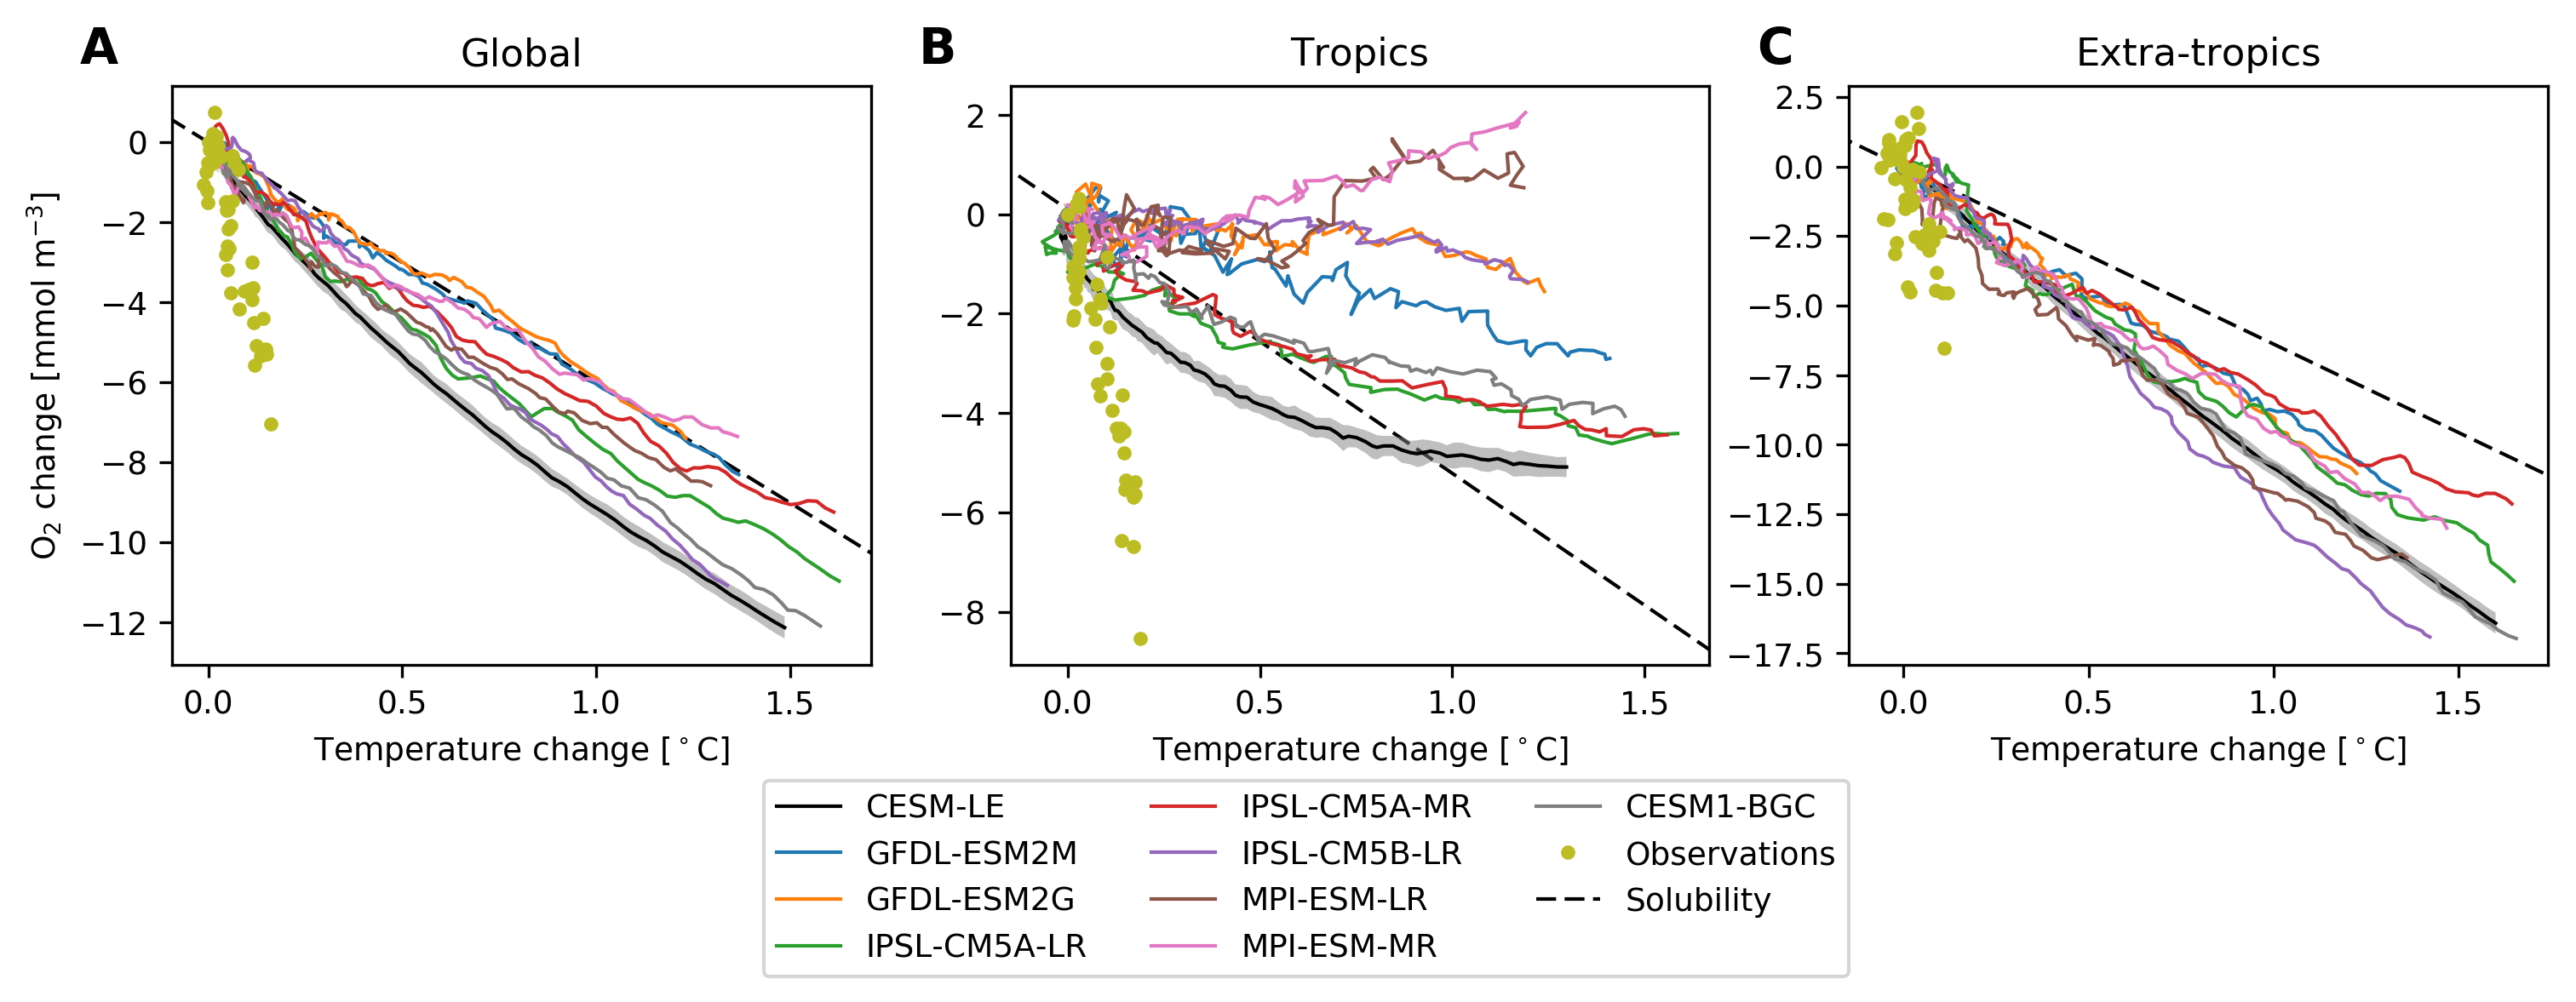

In [26]:
plot_name = os.path.join(diro['fig'],'o2change-temp-phase-diag.pdf')
fig = plt.figure(figsize=(12,3),dpi=300)
gs = gridspec.GridSpec(1,3)
matplotlib.rcParams['contour.negative_linestyle'] = 'solid'
 
for ir,region in enumerate(['Global','Tropics','Extra-tropics']):
    i = region_names.index(region)

    ax = fig.add_subplot(gs[0,ir])
    ax.plot(dcesm_le[1].TEMP[:,i],dcesm_le[1].O2[:,i],'k-',linewidth=1.,label='CESM-LE')
    ax.fill_between(dcesm_le[1].TEMP[:,i],dcesm_le[1].O2[:,i]+scesm_le[1].O2[:,i],dcesm_le[1].O2[:,i]-scesm_le[1].O2[:,i],
                  facecolor='gray',alpha=0.5)

    for im,m in enumerate(cmip.model.values):
        ax.plot(dcmip[1].TEMP[im,:,i],dcmip[1].O2[im,:,i],'-',linewidth=1,label=m)

    ax.plot(dobs[1].TEMP[:,i],dobs[1].O2[:,i],'.',label='Observations')

    xlm = ax.get_xlim()
    ylm = ax.get_ylim()
    ax.plot(O2sat_x[1][:,i],O2sat_y[1][:,i],'--',linewidth=1,color='k',label='Solubility',zorder=-10)
    ax.set_xlim(xlm)
    ax.set_ylim(ylm)    
    ax.set_title(region)

axs = fig.get_axes()
handles, labels = ax.get_legend_handles_labels()
axs[-1].legend(handles, labels,loc=0,
           bbox_to_anchor=(0, -0.2),            
           ncol=3, borderaxespad=0.)#,mode="expand")


for i,ax in enumerate(axs):
    ax.set_xlabel('Temperature change [$^\circ$C]')
    if i == 0:
        ax.set_ylabel('O${_{2}}$ change [mmol m$^{-3}$]')

        
alp = [chr(i).upper() for i in range(97,97+26)]
for i,ax in enumerate(axs):
    p = ax.get_position()
    y = p.y1+0.03
    x = p.x0-0.03
    fig.text(x,y,'%s'%alp[i],
             fontsize=14.,
             fontweight = 'semibold')
    
plt.savefig(plot_name,bbox_inches='tight')

2.02269091173


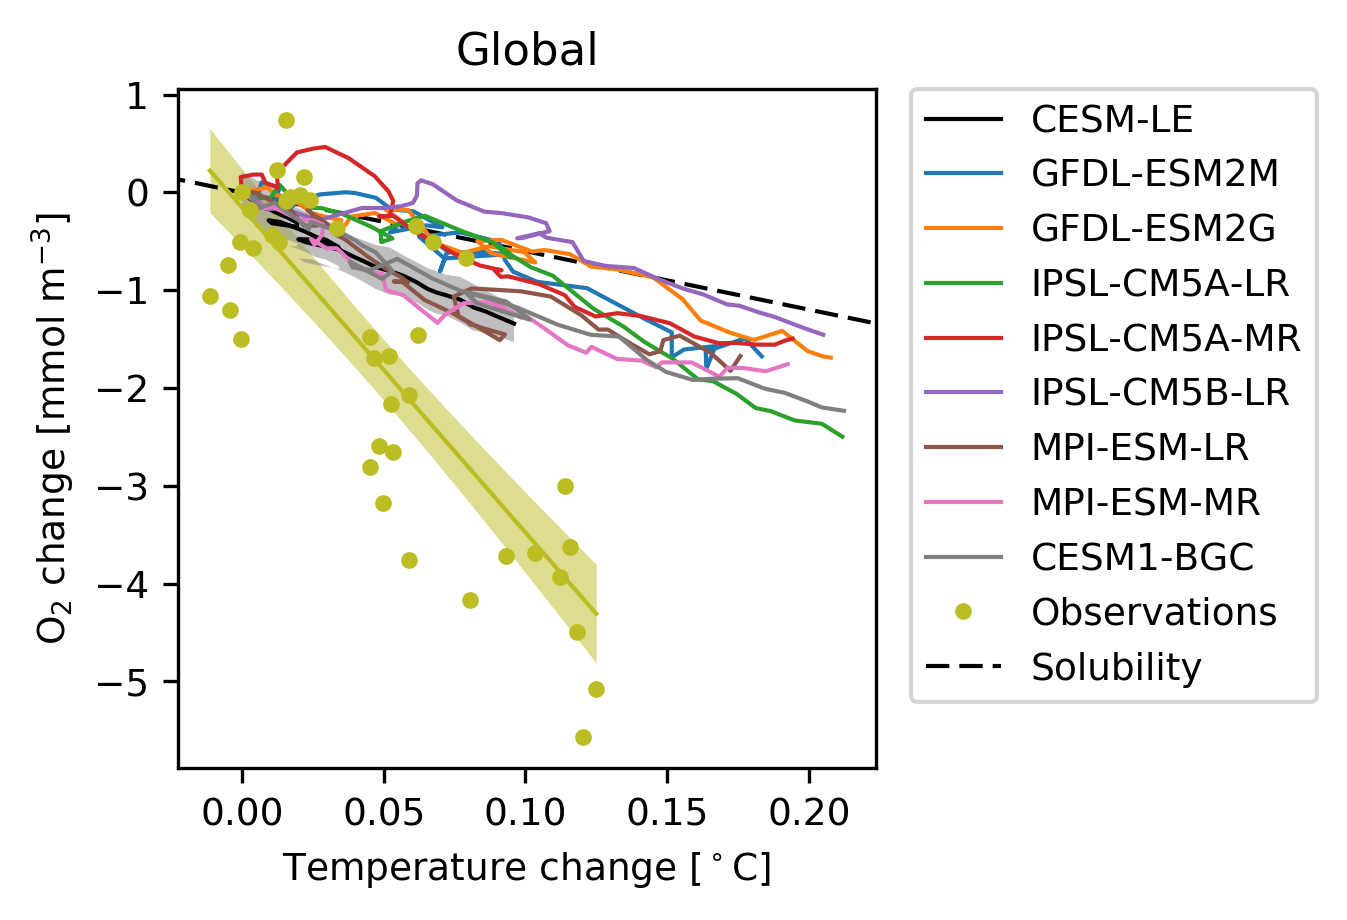

In [10]:
plot_name = os.path.join(diro['fig'],'o2change-temp-phase-diag-1970-2010.pdf')
fig = plt.figure(figsize=(3,3),dpi=300)
gs = gridspec.GridSpec(1,1)
matplotlib.rcParams['contour.negative_linestyle'] = 'solid'
 
    
from scipy import stats
import statsmodels.api as sm

for ir,region in enumerate(['Global']):
    i = region_names.index(region)

    ax = fig.add_subplot(gs[0,ir])
    ax.plot(dcesm_le[0].TEMP[:,i],dcesm_le[0].O2[:,i],'k-',linewidth=1.,label='CESM-LE')
    ax.fill_between(dcesm_le[0].TEMP[:,i],dcesm_le[0].O2[:,i]+scesm_le[0].O2[:,i],dcesm_le[0].O2[:,i]-scesm_le[0].O2[:,i],
                  facecolor='gray',alpha=0.5)

    for im,m in enumerate(cmip.model.values):
        ax.plot(dcmip[0].TEMP[im,:,i],dcmip[0].O2[im,:,i],'-',linewidth=1,label=m)

    xo = dobs[0].TEMP[:,i].values
    yo = dobs[0].O2[:,i].values
    po = ax.plot(xo,yo,'.',label='Observations')

    xlm = ax.get_xlim()
    ylm = ax.get_ylim()

    model = sm.OLS(yo, sm.add_constant(xo))
    fitted = model.fit()
    
    xohat = np.linspace(xo.min(),xo.max(),50)
    yohat = fitted.predict(sm.add_constant(xohat))
    yoerr = yo - fitted.predict(sm.add_constant(xo))
    xbar = np.mean(xo)
    n = len(xo)
    df = n - fitted.df_model - 1
    t = stats.t.ppf(1.-0.025,df=df)
    print t
    s_err = np.sum(np.power(yoerr,2))
    ci = t * np.sqrt((s_err/(n-2))*(1.0/n + (np.power((xohat-xbar),2) / 
                ((np.sum(np.power(xohat,2))) - n*(np.power(xbar,2))))))
    
    ax.plot(xohat,yohat,'-',linewidth=1,color=po[0].get_color())
    ax.fill_between(xohat,yohat+np.abs(ci),yohat-np.abs(ci),
                    color=po[0].get_color(),alpha=0.5,zorder=-10,linewidth=0.)
   

    ax.plot(O2sat_x[0][:,i],O2sat_y[0][:,i],'--',linewidth=1,color='k',label='Solubility',zorder=-10)
    ax.set_xlim(xlm)
    ax.set_ylim(ylm)    
    ax.set_title(region)

handles, labels = ax.get_legend_handles_labels()
plt.legend(handles, labels,loc=2,
           bbox_to_anchor=(1.05, 1),            
           ncol=1, borderaxespad=0.)

axs = fig.get_axes()
for i,ax in enumerate(axs):
    ax.set_xlabel('Temperature change [$^\circ$C]')
    if i == 0:
        ax.set_ylabel('O${_{2}}$ change [mmol m$^{-3}$]')

           
plt.savefig(plot_name,bbox_inches='tight')

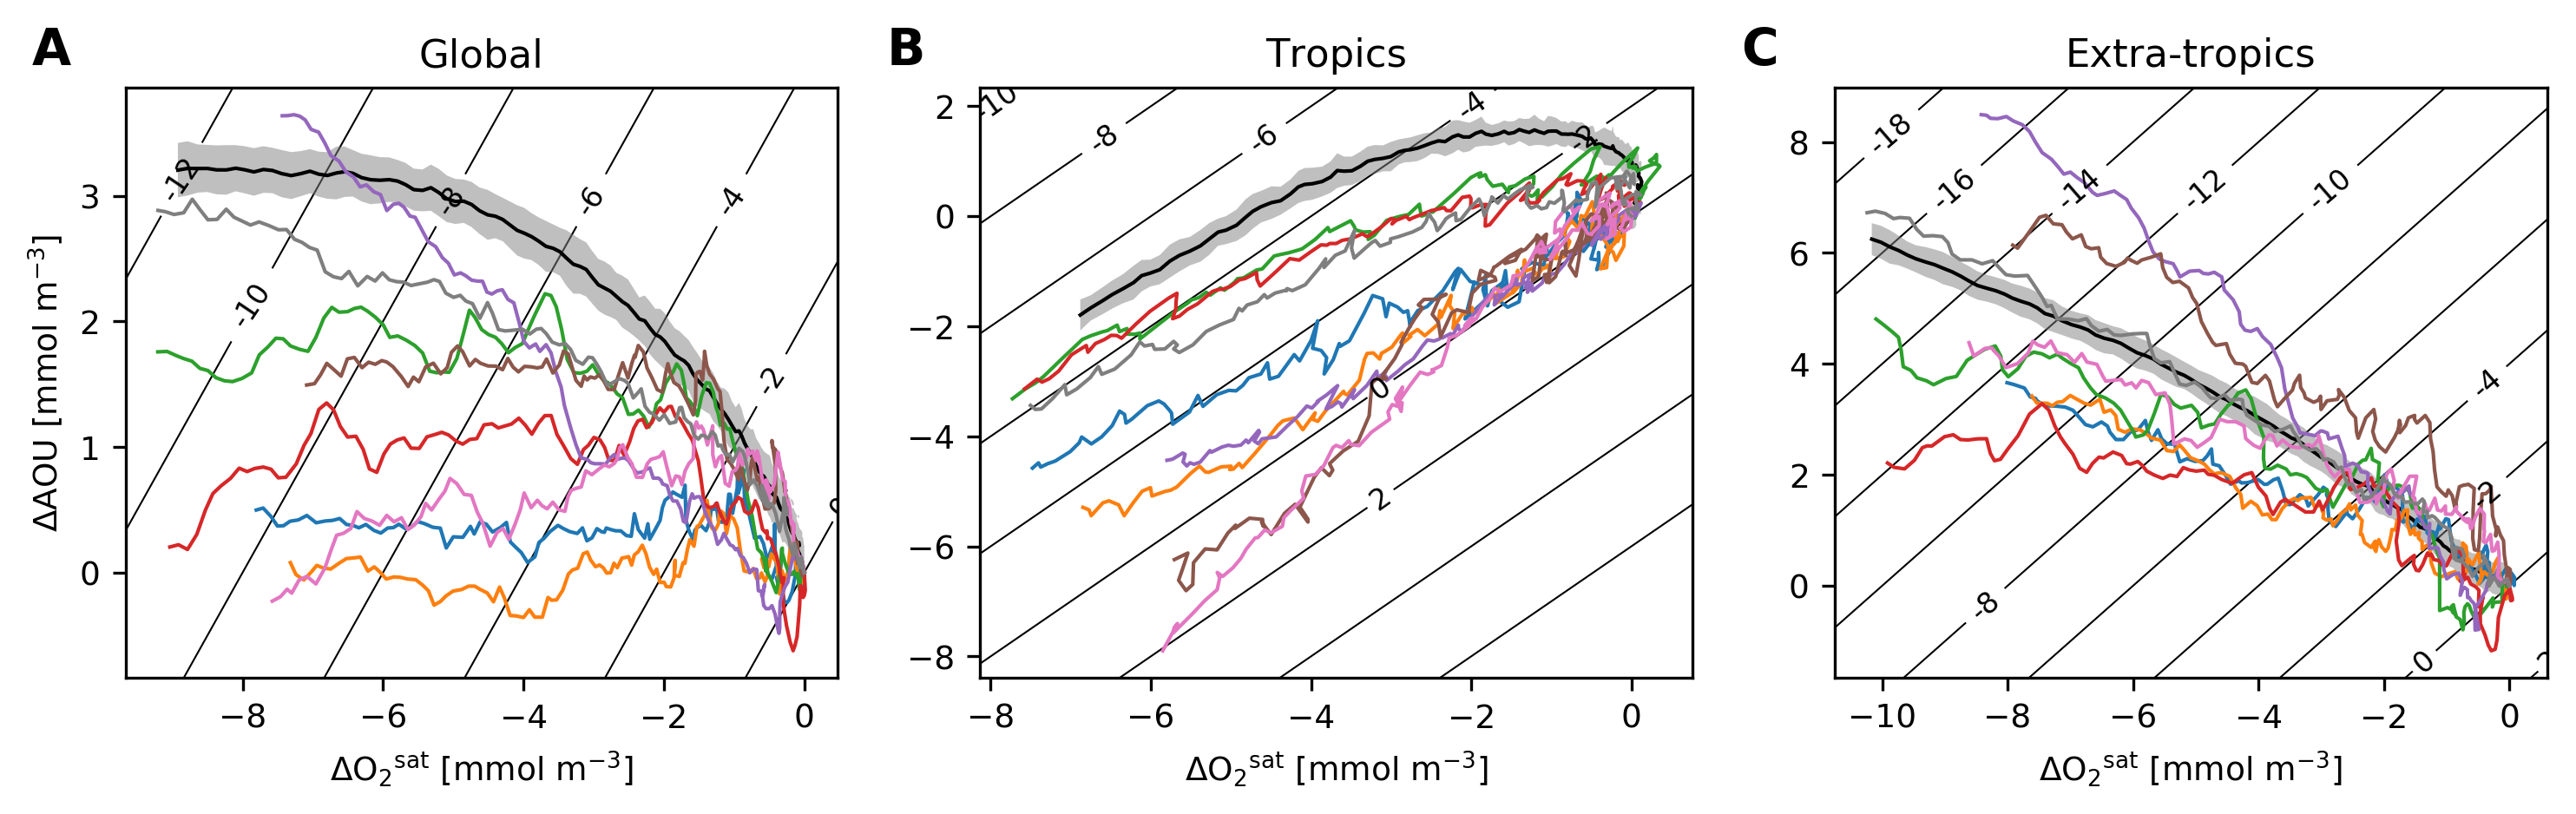

In [27]:
plot_name = os.path.join(diro['fig'],'aou-o2sat-phase-diag.pdf')
fig = plt.figure(figsize=(12,3),dpi=300)
gs = gridspec.GridSpec(1,3)
matplotlib.rcParams['contour.negative_linestyle'] = 'solid'

for ip,region in enumerate(['Global','Tropics','Extra-tropics']):
    i = region_names.index(region)

    ax = fig.add_subplot(gs[0,ip])
    ax.plot(dcesm_le[1].O2sat[:,i],dcesm_le[1].AOU[:,i],'k-',linewidth=1.,label='CESM-LE')
    ax.fill_between(dcesm_le[1].O2sat[:,i],dcesm_le[1].AOU[:,i]+scesm_le[1].AOU[:,i],dcesm_le[1].AOU[:,i]-scesm_le[1].AOU[:,i],
                    facecolor='gray',alpha=0.5)
    
    for im,m in enumerate(cmip.model.values):
        ax.plot(dcmip[1].O2sat[im,:,i],dcmip[1].AOU[im,:,i],'-',linewidth=1,label=m)

    ax.set_title(region)

handles, labels = ax.get_legend_handles_labels()
axs[-1].legend(handles, labels,loc=0,
           bbox_to_anchor=(0, -0.2),            
           ncol=3, borderaxespad=0.)

axs = fig.get_axes()
for i,ax in enumerate(axs):
    xlm = ax.get_xlim()
    ylm = ax.get_ylim()
    x = np.arange(xlm[0]-1,xlm[1]+1.2,0.2)
    y = np.arange(ylm[0]-1,ylm[1]+1.2,0.2)
    x,y = np.meshgrid(x,y)
    z = x - y
    cs = ax.contour(x,y,z,levels=np.arange(-20,7,2),colors='black',linewidths=0.5,zorder=-10)
    cs.levels = [plot_tools.contour_label_format(val) for val in cs.levels]
    fmt = '%r'
    #-- add contour labels
    lb = plt.clabel(cs, fontsize=8,
                   inline = True,
                   fmt=fmt)
    ax.set_xlim(xlm)
    ax.set_ylim(ylm)
    
    ax.set_xlabel('$\Delta$O${_{2}}^{sat}$ [mmol m$^{-3}$]')

    if i == 0:
        ax.set_ylabel('$\Delta$$AOU$ [mmol m$^{-3}$]')

        
alp = [chr(i).upper() for i in range(97,97+26)]
for i,ax in enumerate(axs):
    p = ax.get_position()
    y = p.y1+0.03
    x = p.x0-0.03
    fig.text(x,y,'%s'%alp[i],
             fontsize=14.,
             fontweight = 'semibold')
    
plt.savefig(plot_name,bbox_inches='tight')